In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import sys

### Functions

In [2]:
def get_energy_data(data, time, maxslices, nref, dt, noise, step, e_level, num_runs):
    runs = np.linspace(1, num_runs, num_runs, dtype = int)
    energies = []
    filepath = "/Users/Mandy/Desktop/sdsu_stuff/research/lanczos/Johnson_code/%s/%s/data/"%(data,time)
    for run in runs:
        i = int(run)-1
        filename = "%s_%s_%s_%s_%s_%s_%s.dat"%(data,time,str(maxslices),str(nref),str(dt),str(noise),str(run))
        file = os.path.join(filepath, filename)
        with open(file) as f:
            lines = f.readlines()
            line = lines[step + e_level]
            line = line.split()
            energies.append(line[e_level + 1])

    energies = np.array(energies)
    energies = energies.astype(np.float)
    return energies

def average_energies(energies,num_runs):
    avg_energies = np.mean(energies[0:num_runs-1])
        
    return avg_energies

def std_dev(energies,avg_energies,num_runs):
    num_runs_array = np.linspace(1,num_runs,num_runs, dtype = int)
    sum = 0
    for run in num_runs_array:
        sum = sum + (energies[run-1] - avg_energies)**2
    error = np.sqrt(sum/num_runs)
    sum = 0
        
    return error

def plot(data,time,nref,tau0,dt,noise,maxtimes,results,std_errors,exact,hf):
    plt.errorbar(maxtimes,results,std_errors,marker='o',capsize=5)
    plt.xlabel('k')
    plt.ylabel('Energy (MeV)')
    plt.rcParams['figure.figsize'] = [12.5, 10]
    plt.axhline(y=hf, color='b', linestyle='-')
    plt.axhline(y=exact, color='r', linestyle='-')
    if time=="im":
        plt.legend(['HF Energy', 'Exact Energy', 'ITE'], loc='upper right', numpoints=1)
    elif time=="re":
        plt.legend(['HF Energy', 'Exact Energy', 'RTE'], loc='upper right', numpoints=1)
    

### Hartree-Fock Energies

In [3]:
ne20_hf = -36.404
na22_hf = -54.653
na29_hf = -104.784

### Exact Energies

In [4]:
ne20_exact = [-40.47233,-38.72564,-36.29706,-33.77415,-32.92937]
na22_exact = [-58.44285,-58.10455,-57.57816,-57.48698,-56.90493]
na29_exact = [-107.06200,-106.99092,-105.01745,-104.90842,-104.31960]

### Imaginary- vs. real-time evolution

In [19]:
# Inputs parameters
data = "na22"   # data set to use (ne20, na22, na29)
e_level = 3     # select which energy level to converge to and plot (0-4)
dt = 0.1        # time step size
noise = 0       # added noise (percent)
num_runs = 100  # # of runs
cnvg_pct = 5    # select % to converge to
nref = 1
maxslices = 50

if data=="ne20":
    tau0 = 0.194
    hf = ne20_hf
    exact = ne20_exact[e_level]
elif data=="na22":
    tau0 = 0.238
    hf = na22_hf
    exact = na22_exact[e_level]
elif data=="na29":
    tau0 =  0.336
    hf = na29_hf
    exact = na29_exact[e_level]
else:
    sys.exit("Invalid data input.")
    
if e_level==0:
    tol = cnvg_pct/100*(hf-exact)
else:
    tol = 0.5


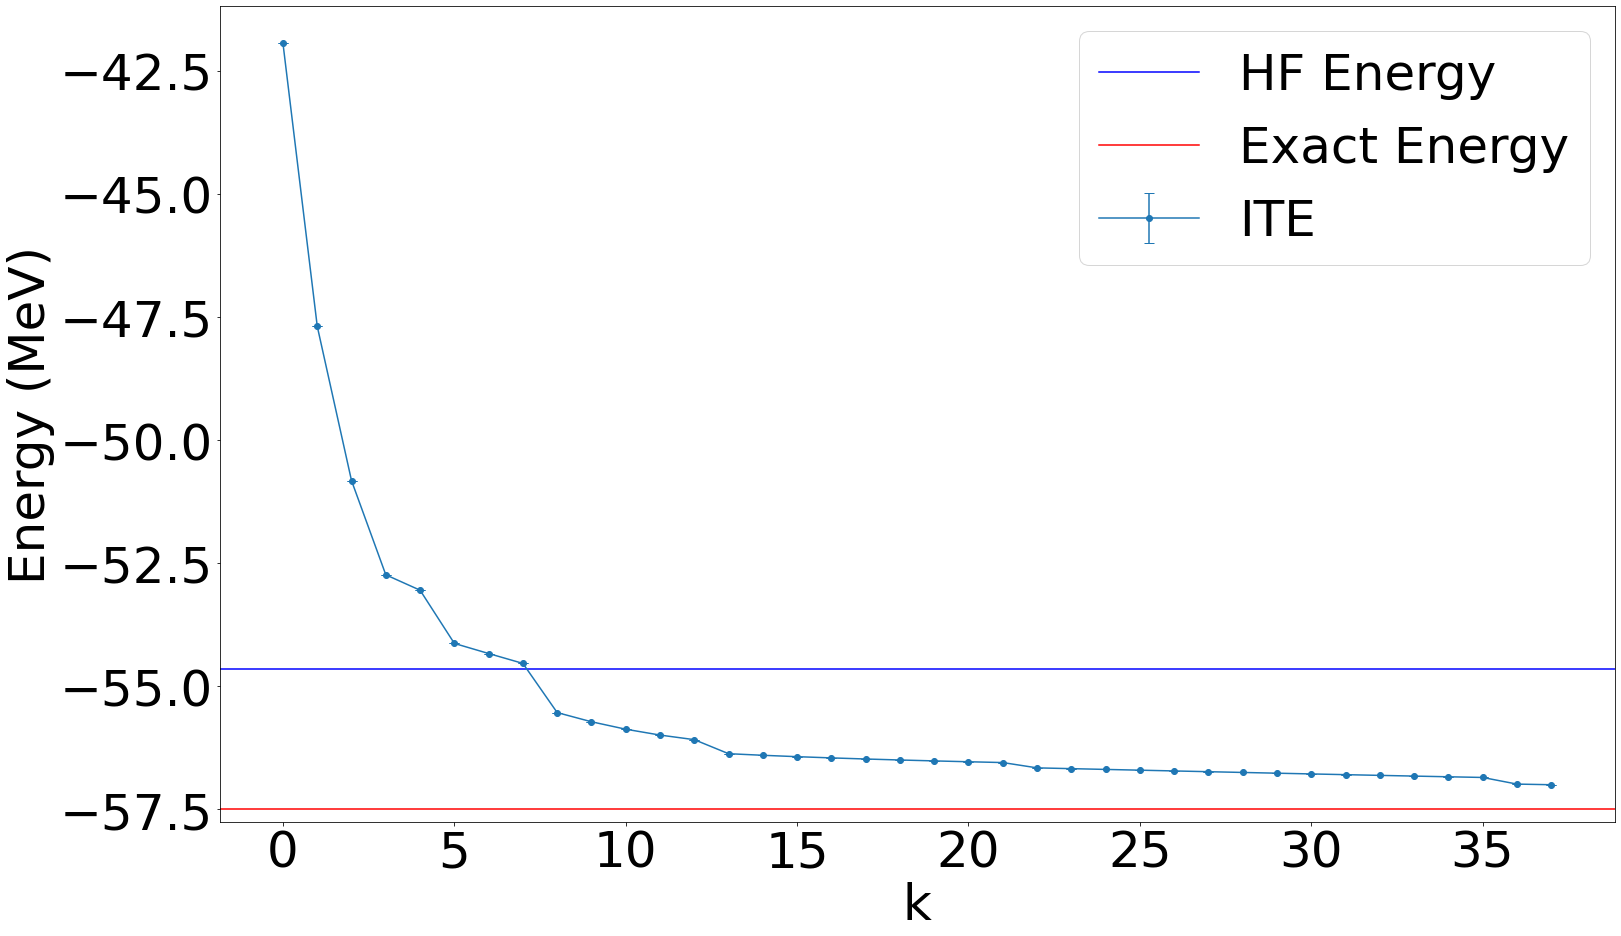

In [20]:
#Imaginary-time evolution
time = "im"     # real- or imaginary-time evolution (re, im)
script="laQMCdemo.sh"

!bash /Users/Mandy/Desktop/sdsu_stuff/research/lanczos/Johnson_code/$script -i $num_runs -d $data -t $time -m $maxslices -r $nref -p $tau0 -s $dt -n $noise >/dev/null 2>&1

energies_im = []
avg_energies_im = []
error_im = []

# Run code until it converges
diff = 100
step = 0
while diff >= tol:
    energies_step = get_energy_data(data,time,maxslices,nref,dt,noise,step,e_level,num_runs)
    avg_energies_step = average_energies(energies_step,num_runs)
    error_step = std_dev(energies_step,avg_energies_step,num_runs)
    diff = avg_energies_step-exact
    step += 1
    energies_im.append(energies_step)
    avg_energies_im.append(avg_energies_step)
    error_im.append(error_step)
    
energies_im = np.concatenate(energies_im)
avg_energies_im = np.stack(avg_energies_im, axis=0)
error_im = np.stack(error_im, axis=0)

k_im = np.linspace(0, step-1, step, dtype = float, endpoint=True)

plot(data,time,nref,tau0,dt,noise,k_im,avg_energies_im[0:len(k_im)],error_im[0:len(k_im)],exact,hf)


In [21]:
#Real-time evolution
time = "re"     # real- or imaginary-time evolution (re, im)
script="claQMCdemo.sh"

!bash /Users/Mandy/Desktop/sdsu_stuff/research/lanczos/Johnson_code/$script -i $num_runs -d $data -t $time -m $maxslices -r $nref -p $tau0 -s $dt -n $noise >/dev/null 2>&1

energies_re = []
avg_energies_re = []
error_re = []

# Run code until it converges
diff = 100
step = 0
while diff >= tol:
    energies_step = get_energy_data(data,time,maxslices,nref,dt,noise,step,e_level,num_runs)
    avg_energies_step = average_energies(energies_step,num_runs)
    error_step = std_dev(energies_step,avg_energies_step,num_runs)
    diff = avg_energies_step-exact
    step += 1
    energies_re.append(energies_step)
    avg_energies_re.append(avg_energies_step)
    error_re.append(error_step)
    
energies_re = np.concatenate(energies_re)
avg_energies_re = np.stack(avg_energies_re, axis=0)
error_re = np.stack(error_re, axis=0)

k_re = np.linspace(0, step-1, step, dtype = float, endpoint=True)

plot(data,time,nref,tau0,dt,noise,k_re,avg_energies_re[0:len(k_re)],error_re[0:len(k_re)],exact,hf)

IndexError: list index out of range

In [ ]:
#Compare
ax = plt.subplot(111)  
ax.spines["top"].set_visible(True)  
ax.spines["right"].set_visible(True)
ax.spines["bottom"].set_visible(True)  
ax.spines["left"].set_visible(True)
plt.rcParams.update({'font.size': 50})
ax.tick_params(direction='in', length=8)
#plt.grid()

plt.axhline(y=hf, color='k', linestyle='dotted',linewidth=5)
plt.axhline(y=exact, color='k', linestyle='-',linewidth=5)

plt.plot(k_im,avg_energies_im[0:len(k_im)],marker='s',linestyle='dashed',color='b',linewidth=5,markersize=20,markeredgewidth=5)
plt.plot(k_re,avg_energies_re[0:len(k_re)],marker='v',linestyle='dashed',color='r',linewidth=5,markersize=20,markeredgewidth=5)

plt.xlabel('S')
plt.ylabel('Energy (MeV)')

#plt.xlim([-1,10])
#ax.set_xticks([2,4,6,8,10,12])
#plt.ylim([-107.5, -104.5])
#ax.set_yticks([-104,-105,-106,-107,-108])

if e_level == 0:
    if data == "ne20":
        plt.xlim([-0.125,6])
        #ax.set_xticks([2,4,6,8,10,12])
        plt.ylim([-41, -36])
        #ax.set_yticks([-104,-105,-106,-107,-108])
    elif data == "na22":
        plt.xlim([-0.25,12])
        #ax.set_xticks([2,4,6,8,10,12])
        plt.ylim([-59, -54])
        #ax.set_yticks([-104,-105,-106,-107,-108])
    elif data == "na29":
        #plt.xlim([-0.125,5])
        #ax.set_xticks([0,1,2,3,4,5])
        plt.ylim([-107.5, -104.5])
        #ax.set_yticks([-104,-105,-106,-107,-108])

plt.rcParams['figure.figsize'] = [25, 15]

plt.legend(['HF', 'exact', 'QITE', 'RTE'], loc='center right', fontsize=30)


plt.savefig('/Users/Mandy/Desktop/sdsu_stuff/research/lanczos/Johnson_code/%s/plots/cmprevo_%s_%selevel_%srefs_%sdt_%snoise.png'%(data,data,str(e_level),str(nref),str(dt),str(noise)), facecolor='white', edgecolor='none', dpi=300, bbox_inches='tight')
    